# Implementing a CNN in Tensorflow

See `cnn_mnist_solution_tf.py` for our implementation. It uses an architecture as recommended in the exercise sheet: Two sets of Conv2D-ReLU-MaxPool operations, followed by a 128-unit dense layer, followed by a 10-unit output layer. Since we are using the 'same' padding technique, convolutions do not change the size of feature maps. However, the max pooling operation _does_ halve height and width each time it is used, so we go from $(28 \times 28) \times 1$ input images to $(7 \times 7) \times 16$ feature maps after the second max pooling.

We've used the low-level Tensorflow API, as requested. But we also implemented our own mini-library, `Kerosey`, to wrap it. This library allows us to create a network by stacking predefined layers (e.g. Conv2D, Relu, MaxPool, Flatten, Dense). It also calculates required weight sizes for each layer, creates and initialises variables, batches the calculation of loss over the training set, provides simple methods such as `train()`, `predict()`, and so on. Kerosey is also contained in `cnn_mnist_solution_tf.py`.



# Comparison of Learning Rates

Using a fixed kernel size of $5 \times 5$, we tested the effect of different learning rates $(0.1, 0.01, 0.001, 0.0001)$ on the learning curve over 30 epochs. The results are shown below.

Best performance is seen with 0.1 and 0.01. A little way behind is 0.001, and a long way behind is 0.0001: we can see very clearly that this last learning rate is simply too slow, and has not produced a useful model after 30 epochs. Note, however, that we're using Stochastic Gradient Descent without momentum; if momentum were used, we could (and perhaps should) use a lower rate.

We don't see any "learning rate too high" effects here, but possibly with an even higher learning rate (e.g. 0.5) we might find that SGD bounces over the surface of the loss function (so to speak), resulting in a learning curve that remains stuck above a certain error level.

In [1]:
%matplotlib inline
import pickle
from cnn_mnist_solution_tf import read_from_json
import matplotlib.pyplot as plt

In [2]:
import pprint

In [3]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.dpi']=200

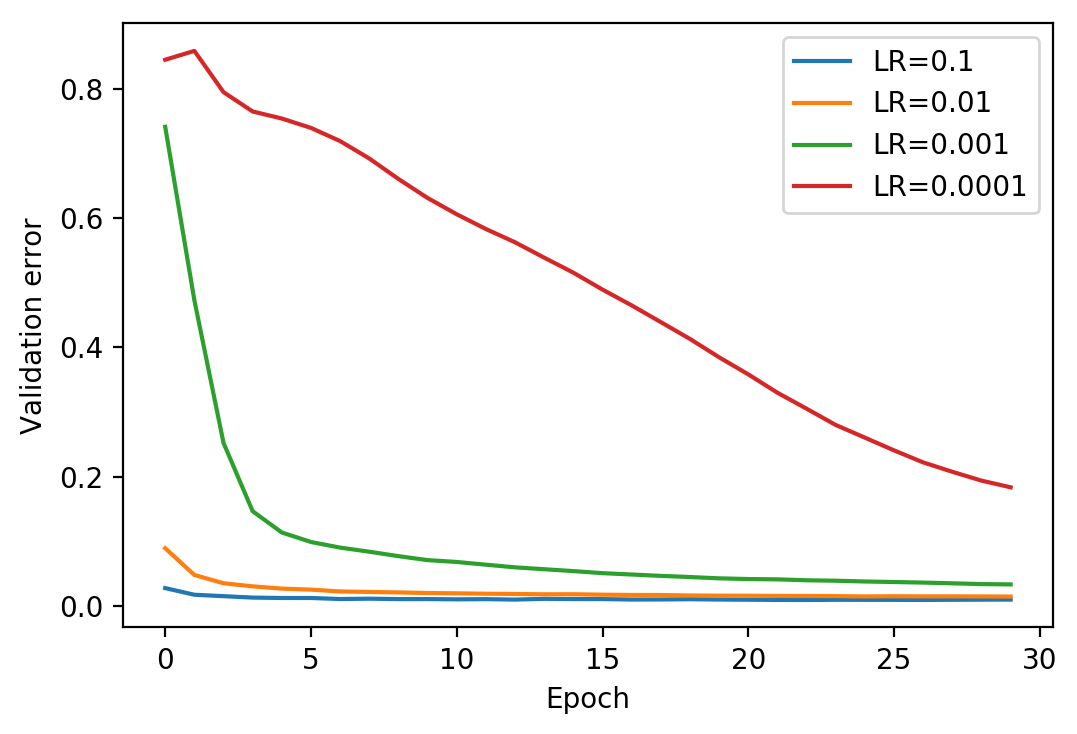

In [4]:
lr_results = [read_from_json('partb_lr_1e-' + str(i)) for i in range(1, 5)]

for r in lr_results:
    plt.plot(r['learning_curve'], label='LR=' + str(r['lr']))

plt.ylabel('Validation error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Comparison of Filter Sizes

Using a fixed learning rate of 0.01, we compared the performance of four different filter sizes. We can see that all of them perform almost equally well, except for $1 \times 1$. This is because with a one-pixel filter, we build a model where neighbouring pixels have no relation to each other: we cannot learn any higher-level features such as curves or discontinuities. This leads to a comparitively poor model for handwriting recognition (although at 6% error, it's not awful).

_Do you have an idea in which scenarios smaller filters might be better than larger filters and vice versa?_

A larger filter contains more parameters (i.e. weights), which gives the model more expressive power. But this is not always a good thing. In addition to the typical danger of overfitting, consider the case where our filter is the same size as the input image. Then it's effectively no longer a convolutional network: we have a fully connected model. 

So, in general, we should choose the minimum filter size that allows us to capture local, low level-features, and successively build higher-level features out of them. The problem is that it's often not obvious to a human observer what this minimum will be! In practice, $3 \times 3$ is widely used. However, larger filter sizes should be useful on images where features are discontinuous -- for example, photographs where there is "pixel noise" between "pixel signals", and we need to look beyond a pixel's immediate neighbours to find meaningful feature relationships.

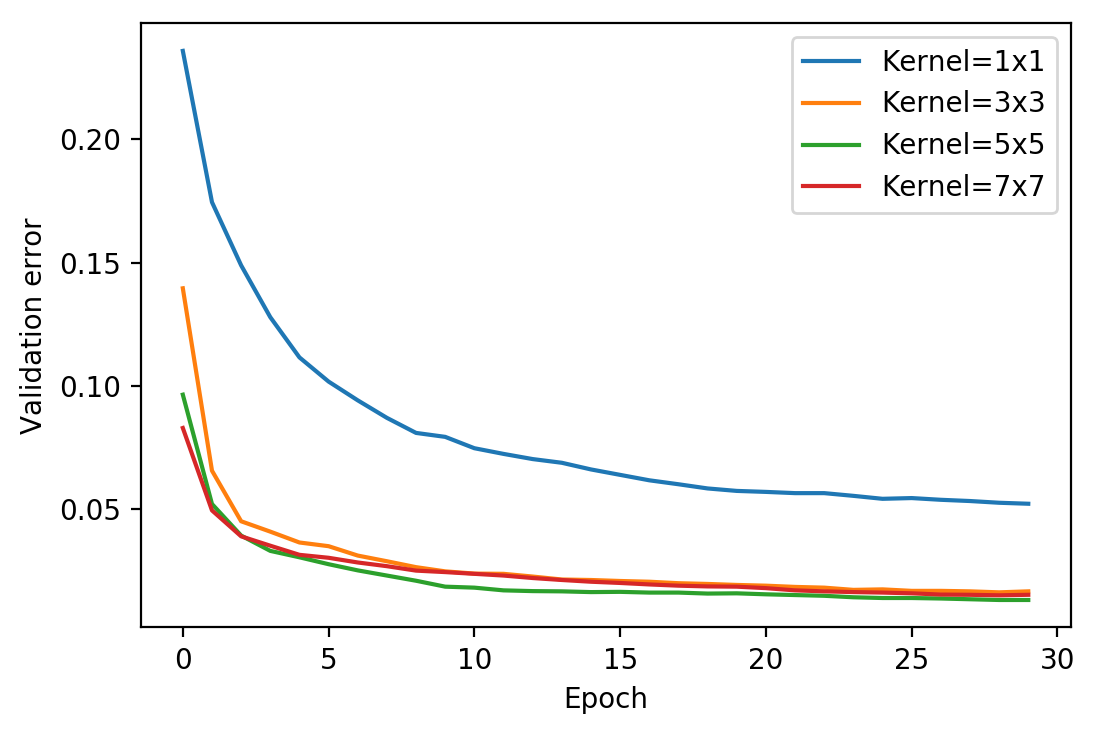

In [5]:
kf_results = [read_from_json('partc_fs-' + str(i)) for i in [1, 3, 5, 7]]

for r in kf_results:
    plt.plot(r['learning_curve'], label='Kernel=' + str(r['filter_size']) + 'x' + str(r['filter_size']))

plt.ylabel('Validation error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Hyperparameter Search

Using the supplied HpBandSter script as a starting point, we used a random search over 50 iterations, with each candidate being trained for 6 epochs. The code for this part is in `random_search_solution_tf.py` 

The progress of our search is shown below. We can see that the best model was found almost immediately, and that there seem to be diminishing returns to time spent on searching. That said, we are working with a low-dimensional hyperparameter space here, and we may also have just been lucky.

(There's also an aspect to model performance that we haven't discussed so far: real-world effectiveness. A model that achieves 99.8% accuracy on MNIST is not just 0.5% better than a model that achieves 99.3%. The former would be a world record breaker, and the latter is now almost trivial. So in this sense it might well be worth searching for as long as it takes to find each additional tiny increase in accuracy.)

We trained this final model for 50 epochs on a combined training + validation dataset. The final test error was **0.82%**. Its learning curve is shown on the final page of this report.

In [6]:
# import search results
res = pickle.load(open('results/hypersearch.pkl','rb'))

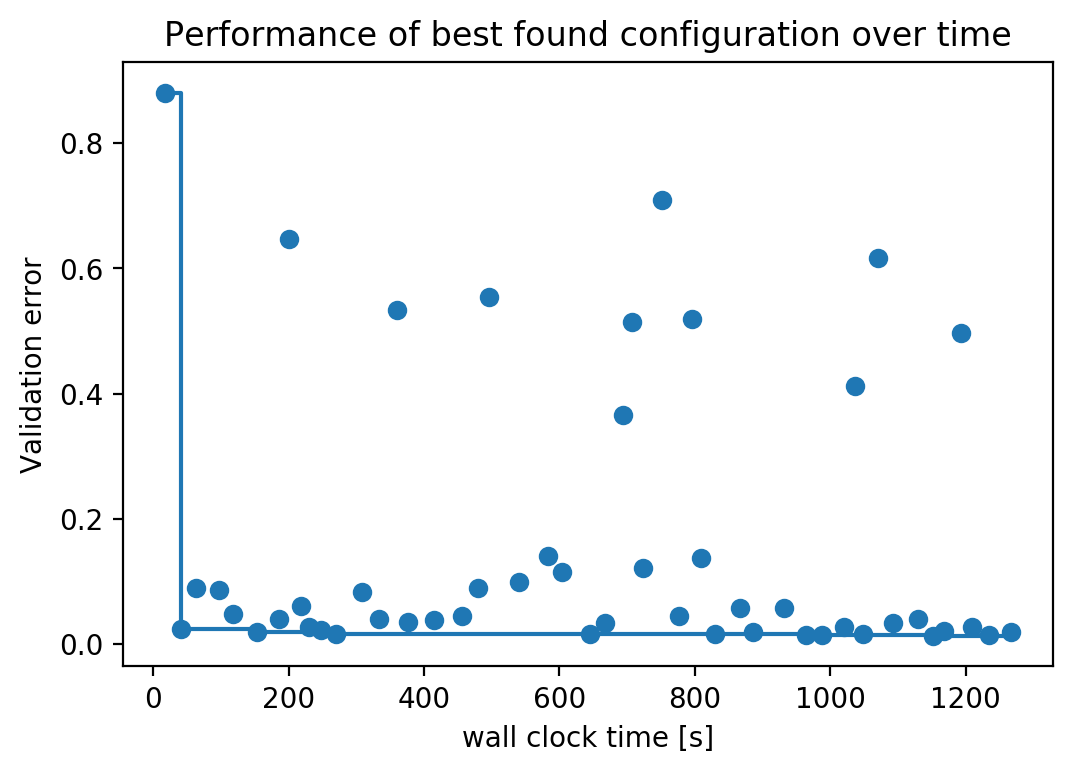

In [7]:
# plot the validation performance of the best found conﬁguration after each iteration
import hpbandster.visualization as hpvis
fig, ax = hpvis.losses_over_time(res.get_all_runs())
ax.set_title('Performance of best found configuration over time')
ax.set_ylabel('Validation error')
ax.legend().set_visible(False)
plt.show()

**Best model found through random search**

In [8]:
incumbent_results = read_from_json('incumbent')
experimental_results = read_from_json('experimental')

In [9]:
pprint.pprint(res.get_id2config_mapping()[res.get_incumbent_id()]['config'])
print ("Final test error: {:4f}".format(1 - incumbent_results['learning_curve'][-1]))

{'batch_size': 36,
 'filter_size': 5,
 'lr': 0.05172120679952766,
 'num_filters': 24}
Final test error: 0.008200


# Extra: Can we improve on Random Search?

In random search, we're essentially throwing darts into hyperparameter space and picking the best result we find. But can we use the results of the entire search to predict where an even better result may be found?

For fun, we tried this approach:

* Collect the hyperparameter settings of each iteration into a $50 \times 4$ $\mathbf{X}$ dataset

* Collect the final validation error of each iteration into a $50 \times 1$ $\mathbf{y}$ dataset

* Train a simple neural network on the data (two fully-connected hidden layers of 20 and 10 units, tanh activation, MSE loss). Since data was scarce and we did not intend to perform any hyperparameter optimisation for this meta-model, we used the entire dataset for training.

So now we have a model of validation performance as a function of the hyperparameters. Now to find the $\mathbf{x}$ vector that minimises $y$, within the hyperparameter constraints laid out in the exercise. This could have been done via constrained gradient descent on $\nabla_y \mathbf{x}$, but instead we used particle swarm optimisation, since it's an easier out-of-the-box tool to work with. Our code for this task is in `hypersearch.py`.

The "ideal" settings found through this approach are shown below. Compared to the best random-search model, we see a significantly higher learning rate (actually the maximum), and a smaller batch and filter size. Again, we trained this model for 50 epochs on a combined training + validation dataset. The final test error was **0.77%**.

**Best model found through hyperparameter metamodelling**

In [10]:
pprint.pprint({x: experimental_results[x] for x in experimental_results if x not in ('learning_curve','name')})
print ("Final test error: {:4f}".format(1 - experimental_results['learning_curve'][-1]))

{'batch_size': 25,
 'filter_size': 5,
 'lr': 0.09999989512720447,
 'num_filters': 18}
Final test error: 0.007700


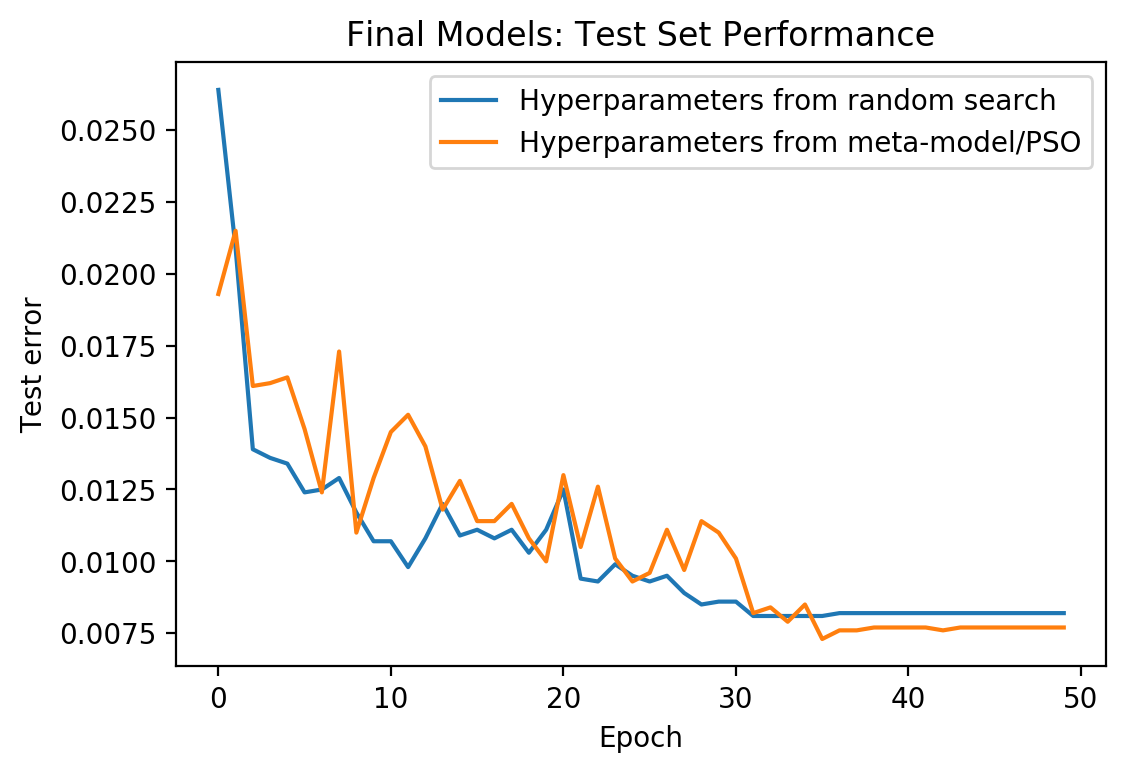

In [11]:
plt.plot([1 - a for a in incumbent_results['learning_curve']], label='Hyperparameters from random search')
plt.plot([1 - a for a in experimental_results['learning_curve']], label='Hyperparameters from meta-model/PSO')
plt.title('Final Models: Test Set Performance')
plt.legend()
plt.ylabel('Test error')
plt.xlabel('Epoch')
plt.show()